In [1]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
params = {'text.color' : '#3B3B3B',
          'font.size':'20',
          'legend.fontsize': '18',
          'figure.figsize': (16, 7),
         'axes.labelsize': '18',
         'axes.titlesize':'18',
         'axes.labelcolor' : '#3B3B3B', # 9A9A2E from template
          'xtick.color' : '#3B3B3B',
          'ytick.color' : '#3B3B3B',
         'xtick.labelsize':'18',
         'ytick.labelsize':'18'}
plt.style.use('bmh')
%matplotlib inline
from pypsa.linopf import (get_var, define_constraints, linexpr, join_exprs,
                          network_lopf, ilopf)

from six import iteritems

In [2]:
#basedir = "../" 
basedir = "~/mnt/lin/pypsa-eur/pypsa-eur/results/"

In [5]:
nodal_capacities = pd.read_csv(basedir+"networks/iteration5/robust_capacities.csv",index_col=list(range(2)),header=[0])
links_capacities = nodal_capacities.loc['links']
links_capacities

,2013,2014,2015,2016,2017,2018,robust_capacities
12998,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
14531,250.0,250.0,250.0,250.0,250.0,250.0,250.0
14537,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14538,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14539,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
T20,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T21,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T22,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T23,0.0,0.0,0.0,0.0,0.0,0.0,0.0


                2013      2014      2015      2016      2017      2018
iteration0  3.016237  2.890987  2.984812  3.047696  2.966786  3.095333
iteration1  3.074623  3.009682  3.019045  3.100090  3.007185  3.042576
iteration2  3.077503  3.051547  3.048031  3.102335  3.043178  3.053686
iteration3  3.082875  3.067586  3.063901  3.104667  3.063790  3.066559
iteration4  3.043606  3.043152  3.056919  3.046901  3.057096  3.040049
iteration5  3.065082  3.065082  3.065082  3.065082  3.065082  3.065082


Text(0, 0.5, 'Optimal capacities from weather years [TW]')

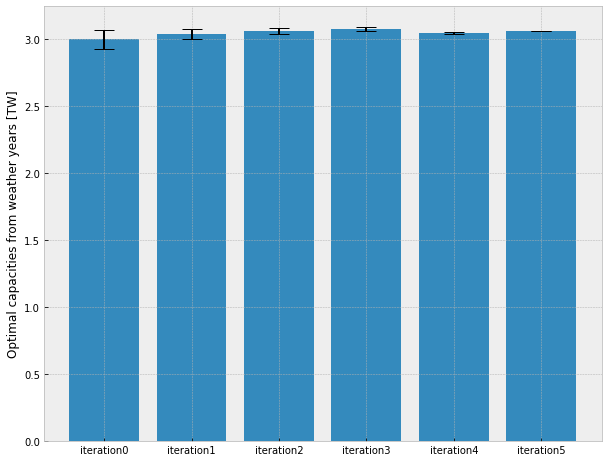

In [4]:

columns = ["iteration0", "iteration1", "iteration2","iteration3","iteration4", "iteration5"]
index = ["2013", "2014", "2015","2016", "2017", "2018"]
cost = pd.DataFrame(index = index, columns = columns)

for i in range(0,6):
    cost_df = pd.read_csv(basedir + "summary/csvs/iteration"+str(i)+"/capacities.csv",index_col=list(range(2)),header=[0])
    total = cost_df.sum()/1e6
    cost["iteration"+str(i)] = total

cost = cost.T
print(cost)
plt.figure(figsize=(10,8))    
plt.bar(cost.index, cost.mean(axis=1),yerr=cost.std(axis=1), capsize=10) 
plt.ylabel("Optimal capacities from weather years [TW]")



In [4]:
links_capacities = nodal_capacities.loc['links']
n = n2014_pre
links_capacities

# links_dc_i = n.links.index[n.links.p_nom_extendable]
# links_dc_i
links_capacities.loc[links_dc_i, "robust_capacities"]
n.links.loc[links_dc_i, 'p_nom'] = links_capacities.loc[links_dc_i, "robust_capacities"]
n.links.loc[links_dc_i, 'p_nom_extendable'] = False
n.links.loc[links_dc_i, 'p_nom']

NameError: name 'nodal_capacities' is not defined

Text(0, 0.5, 'Average annual costs (Billion € ${a^-1}$ )')

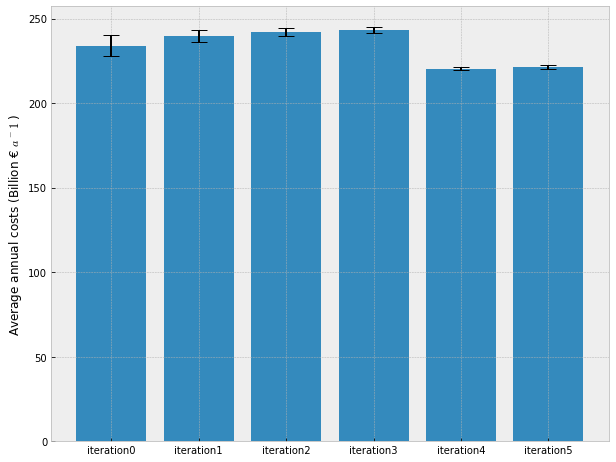

In [3]:

columns = ["iteration0", "iteration1", "iteration2","iteration3","iteration4", "iteration5"]
index = ["2013", "2014", "2015","2016", "2017", "2018"]
cost = pd.DataFrame(index = index, columns = columns)

for i in range(0,6):
    cost_df = pd.read_csv(basedir + "summary/csvs/iteration"+str(i)+"/costs.csv",index_col=list(range(3)),header=[0])
    total = cost_df.sum()/1e9
    cost["iteration"+str(i)] = total
cost = cost.T
cost
plt.figure(figsize=(10,8))    
plt.bar(cost.index, cost.mean(axis=1),yerr=cost.std(axis=1), capsize=8) 
plt.ylabel("Average annual costs (Billion € ${a^-1}$ )")




In [ ]:
def load_costs(Nyears=1., tech_costs=None, config=None, elec_config=None):
    if tech_costs is None:
        tech_costs = snakemake.input.tech_costs

    if config is None:
        config = snakemake.config['costs']

    # set all asset costs and other parameters
    costs = pd.read_csv(tech_costs, index_col=list(range(3))).sort_index()

    # correct units to MW and EUR
    costs.loc[costs.unit.str.contains("/kW"),"value"] *= 1e3
    costs.loc[costs.unit.str.contains("USD"),"value"] *= config['USD2013_to_EUR2013']

    costs = (costs.loc[idx[:,config['year'],:], "value"]
             .unstack(level=2).groupby("technology").sum(min_count=1))

    costs = costs.fillna({"CO2 intensity" : 0,
                          "FOM" : 0,
                          "VOM" : 0,
                          "discount rate" : config['discountrate'],
                          "efficiency" : 1,
                          "fuel" : 0,
                          "investment" : 0,
                          "lifetime" : 25})

    costs["capital_cost"] = ((annuity(costs["lifetime"], costs["discount rate"]) +
                             costs["FOM"]/100.) *
                             costs["investment"] * Nyears)

    costs.at['OCGT', 'fuel'] = costs.at['gas', 'fuel']
    costs.at['CCGT', 'fuel'] = costs.at['gas', 'fuel']

    costs['marginal_cost'] = costs['VOM'] + costs['fuel'] / costs['efficiency']

    costs = costs.rename(columns={"CO2 intensity": "co2_emissions"})

    costs.at['OCGT', 'co2_emissions'] = costs.at['gas', 'co2_emissions']
    costs.at['CCGT', 'co2_emissions'] = costs.at['gas', 'co2_emissions']

    costs.at['solar', 'capital_cost'] = 0.5*(costs.at['solar-rooftop', 'capital_cost'] +
                                             costs.at['solar-utility', 'capital_cost'])

    def costs_for_storage(store, link1, link2=None, max_hours=1.):
        capital_cost = link1['capital_cost'] + max_hours * store['capital_cost']
        if link2 is not None:
            capital_cost += link2['capital_cost']
        return pd.Series(dict(capital_cost=capital_cost,
                              marginal_cost=0.,
                              co2_emissions=0.))

    if elec_config is None:
        elec_config = snakemake.config['electricity']
    max_hours = elec_config['max_hours']
    costs.loc["battery"] = \
        costs_for_storage(costs.loc["battery storage"], costs.loc["battery inverter"],
                          max_hours=max_hours['battery'])
    costs.loc["H2"] = \
        costs_for_storage(costs.loc["hydrogen storage"], costs.loc["fuel cell"],
                          costs.loc["electrolysis"], max_hours=max_hours['H2'])

    for attr in ('marginal_cost', 'capital_cost'):
        overwrites = config.get(attr)
        if overwrites is not None:
            overwrites = pd.Series(overwrites)
            costs.loc[overwrites.index, attr] = overwrites

    return costs

In [ ]:
tech_costs = "data/costs.csv"
load_costs(Nyears=1., tech_costs=tech_costs, config=None, elec_config=None)